In [234]:
import functools
from functools import partial
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import yaml

%load_ext autoreload
%autoreload 2

%matplotlib inline

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
from scipy.stats import kendalltau, rankdata
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [431]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split, MOVIELENS_1M,MetaData, get_dataset
from lda4rec.evaluations import summary
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks, dist_overlap, norm_entropy, Config, apply_along_dim
from lda4rec import lda

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

In [4]:
import neptune.new as neptune
# init dummy neptune to avoid problems with logging
neptune.init(mode='offline') 

offline/63643a2a-450b-47b6-88c8-09f532eccdb6
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [6]:
ic.configureOutput(argToStringFunction=ic_str)

# Ideen

* 10 Titel der jeweils wichtigsten cohorts
* Entropy der User
* So eine Spinne https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_scatter.html#sphx-glr-gallery-pie-and-polar-charts-polar-scatter-py or better violin plot
* Correlation der Filme, die jemand mit wenig Konformitaet geschaut hat verglichen mit jemanden der das stark getan hat.
* wie stark correlelliert der popularity mit der empirisch ermittelten popularitaet? Rank vergleich
* Wie Trennungsscharf sind cohorten? 
    * ueber verschiedene Dimensionsn https://rdrr.io/cran/StatMatch/man/comp.prop.html
    * die 20 höchsten Werte vegleichen
    * Mensch mit hoher und niedriger Konformität vergleichen
    * wie stark sind die interagierten items in einer kohorte vertreten? Korrelation?
* Fingerprints von usern.
* Leute mit mehr popularity, schauen auch populärere Filme, t-test
* 
    

## Interpretation

In [175]:
md = MetaData.from_movielens_1m()

In [429]:
cfg = Config(Path('../configs/exp_25.yaml'))
exp_cfg = cfg["experiment"]

In [457]:
exp_cfg

{'dataset': 'movielens-1m',
 'dataset_seed': 1729,
 'est_params': {'batch_size': 256,
  'embedding_dim': 16,
  'learning_rate': 0.001,
  'n_iter': 200},
 'estimator': 'MFEst',
 'interaction_pivot': 0,
 'max_user_interactions': 200,
 'min_user_interactions': 20,
 'model_seed': 1981,
 'train_test_split': 'random_train_test_split'}

In [504]:
data = get_dataset(exp_cfg["dataset"], data_dir=cfg["main"]["data_path"])
data.implicit_(exp_cfg["interaction_pivot"])  # implicit feedback
data.max_user_interactions_(exp_cfg["max_user_interactions"], rng=data_rng)
data.min_user_interactions_(exp_cfg["min_user_interactions"])

array([], dtype=int64)

In [505]:
train, rest = random_train_test_split(data, test_percentage=0.10, rng=data_rng)
test, valid = random_train_test_split(rest, test_percentage=0.5, rng=data_rng)

In [506]:
est = MFEst(**exp_cfg["est_params"])
est.load("../models/exp_25_MFEst_2021-12-28_18:02:01.model", data)

<MFEst: MFNet(
  (user_embeddings): ScaledEmbedding(6040, 16)
  (item_embeddings): ScaledEmbedding(3706, 16)
  (item_biases): ZeroEmbedding(3706, 1)
)>

In [507]:
v, t, h, b = est.get_lda_params()

## Cohort overlap of N most likely values of different cohorts

In [508]:
from string import ascii_letters
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

In [509]:
h.shape

torch.Size([3706, 32])

In [510]:
def cohort_overlap_top_n(cohorts, n=10):
    n_cohorts = cohorts.shape[1]
    top_n = [set(c.argsort(descending=True)[:n].numpy()) for c in torch.unbind(cohorts, dim=1)]
    return np.array([[len(top_n[i] & top_n[j]) / n for j in np.arange(n_cohorts)] for i in np.arange(n_cohorts)])

<AxesSubplot:ylabel='Count'>

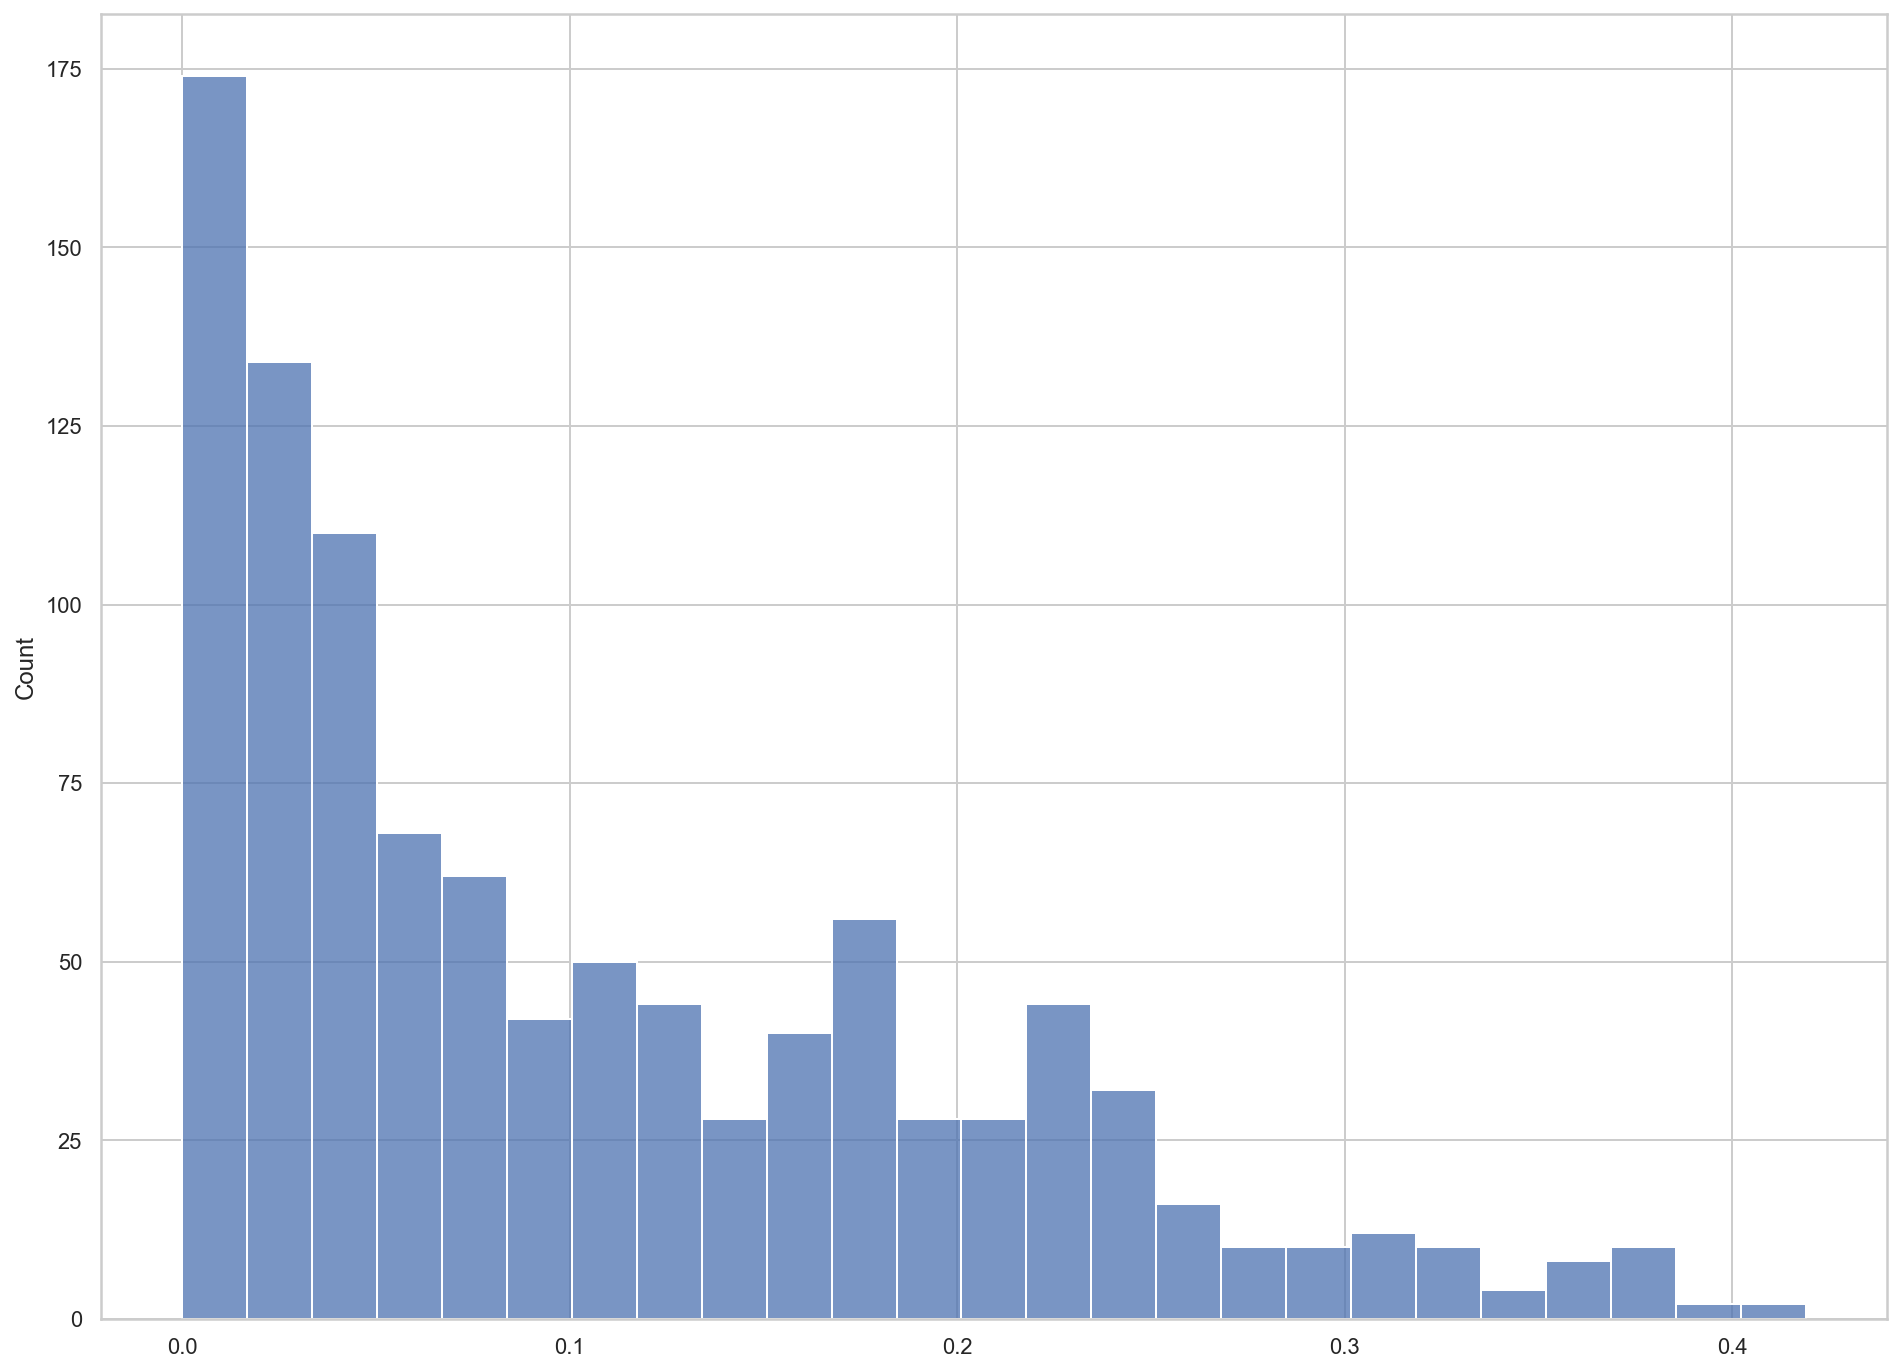

In [511]:
overlap = cohort_overlap_top_n(h, n=370)
d0_overlap = overlap.copy()
np.fill_diagonal(d0_overlap, 0)
sns.histplot(d0_overlap.flatten(), bins=25)

Rank der top N besser.

<AxesSubplot:>

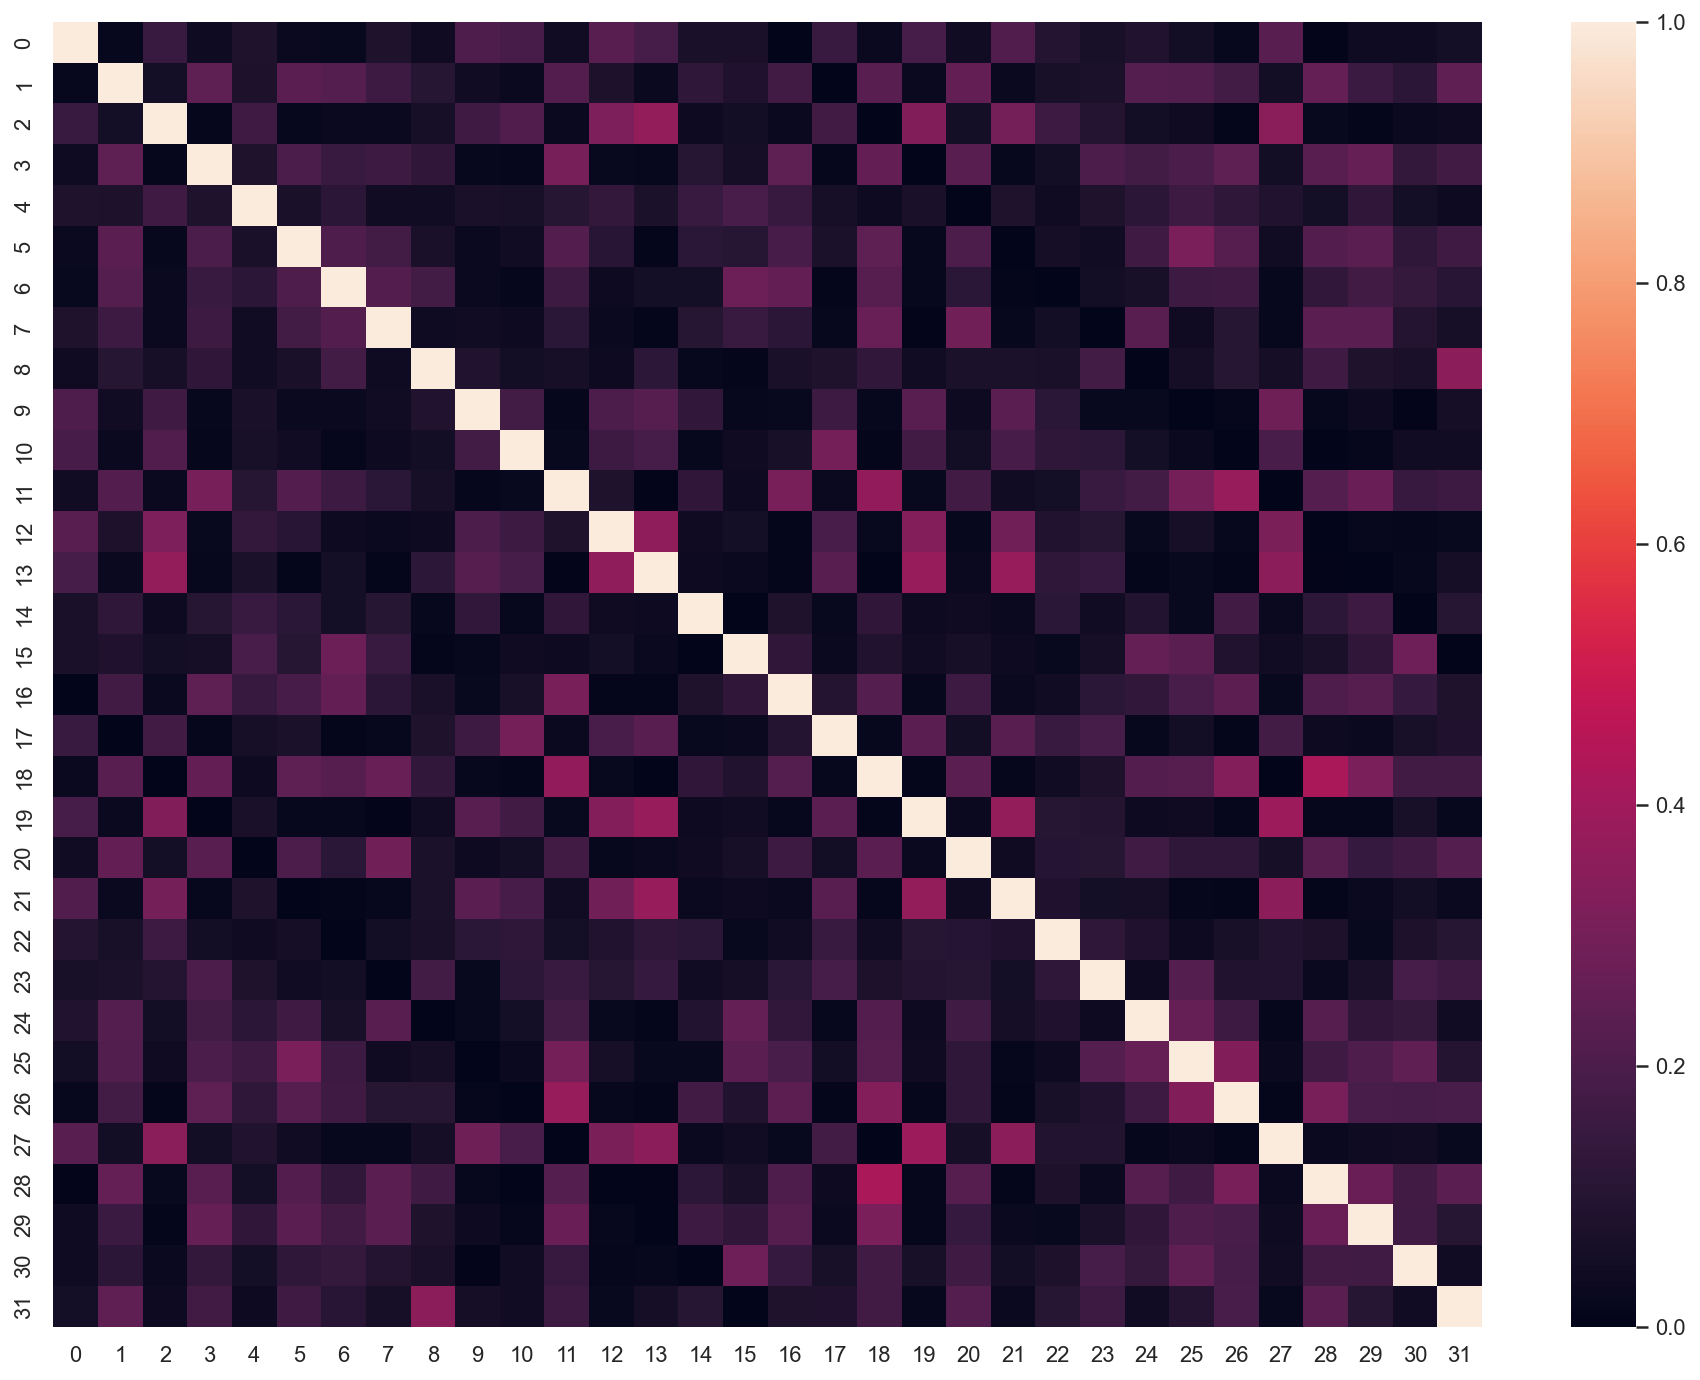

In [512]:
sns.heatmap(overlap)

In [513]:
def cohort_kendall_tau(cohorts):
    n_cohorts = cohorts.shape[1]
    return np.array([[kendalltau(c.numpy(), d.numpy(), variant='c').correlation for d in torch.unbind(cohorts, dim=1)] for c in torch.unbind(cohorts, dim=1)])

In [514]:
ctaus = cohort_kendall_tau(h)

<AxesSubplot:ylabel='Count'>

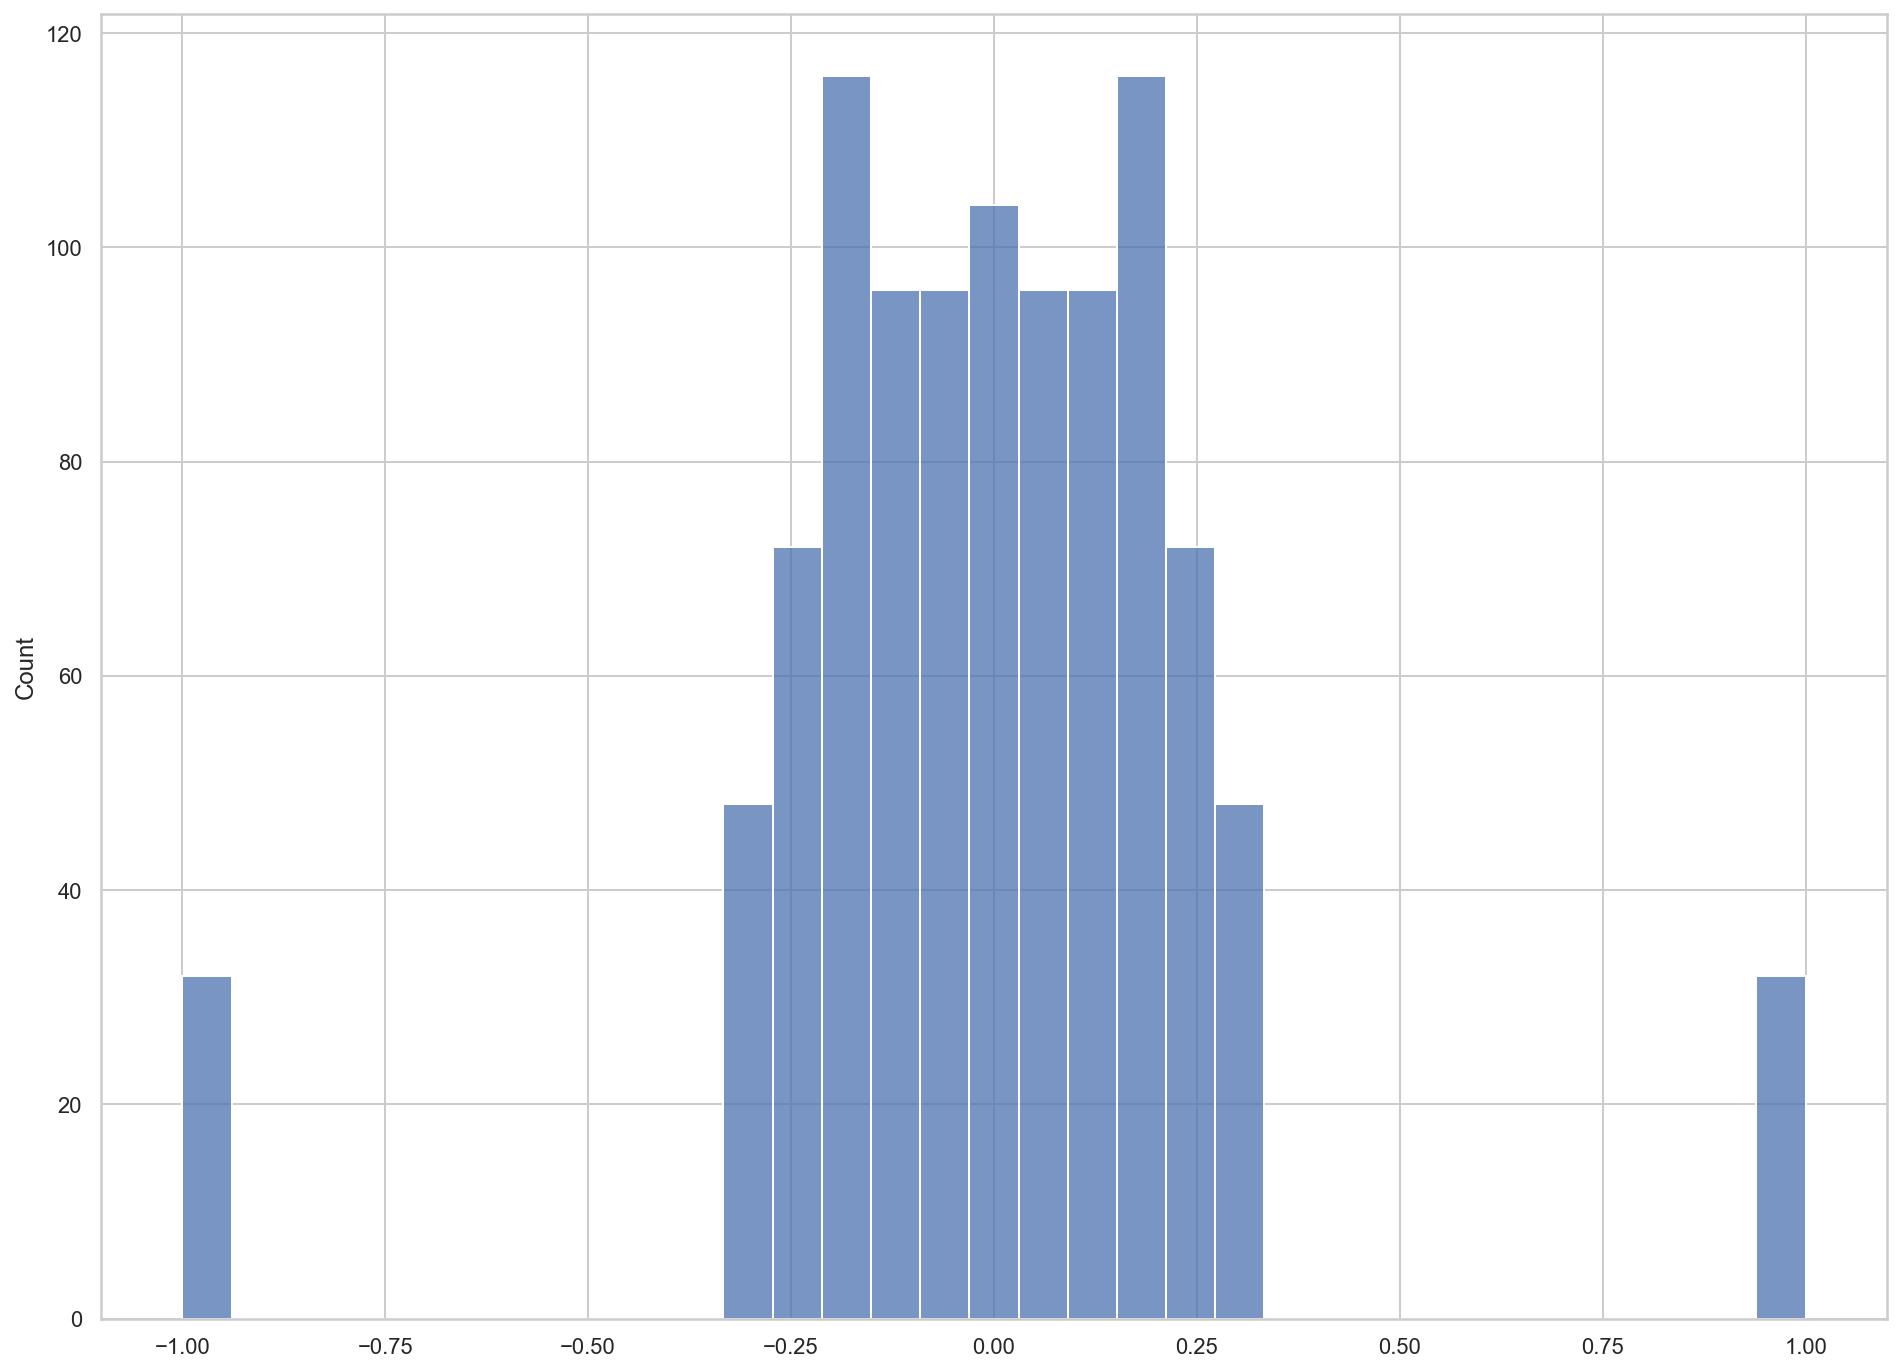

In [515]:
sns.histplot(ctaus.flatten())

In [516]:
kendalltau(torch.unbind(h, dim=1)[0], torch.unbind(h, dim=1)[0])

KendalltauResult(correlation=1.0, pvalue=0.0)

## General overlap of the cohorts

In [517]:
N = h.shape[1]
res = [dist_overlap(h[:,i], h[:,j])  for i in range(N) for j in range(N) if j > i]

In [518]:
min(res), max(res)

(0.7067843675613403, 0.8785260915756226)

## N most importants items of a cohort

In [519]:
def n_most_important_items_per_cohort(cohorts, metadata, n=10):
    c_items = [c.argsort(descending=True)[:n].numpy() for c in torch.unbind(cohorts, dim=1)]
    return [list(map(lambda x: metadata.item_info(x)['name'], items)) for items in c_items]

In [520]:
#n_most_important_items_per_cohort(h, md)

## Popularity Comparison

In [577]:
df = data.to_pandas()

In [578]:
emp_pops = np.zeros(data.n_items, dtype=int)

In [579]:
val_counts = df['item_id'].value_counts()

In [580]:
emp_pops[val_counts.index] = val_counts.to_numpy()

In [581]:
kendalltau(emp_pops, b)

KendalltauResult(correlation=0.6504477054053043, pvalue=0.0)

Quite strong according to http://polisci.usca.edu/apls301/Text/Chapter%2012.%20Significance%20and%20Measures%20of%20Association.htm

## Belonging to different cohohorts

In [591]:
df = train.to_pandas()

In [592]:
def get_cohorts(cohorts, df):
    n_cohorts = cohorts.shape[1]
    items = df['item_id'].to_numpy()
    cohorts = np.array([cohorts[i].argmax() for i in items])
    counts = np.zeros(n_cohorts)
    nums, n_counts = np.unique(cohorts, return_counts=True)
    counts[nums] = n_counts / n_counts.sum()
    return counts
    
res = df.groupby('user_id', as_index=False).apply(partial(get_cohorts, h))

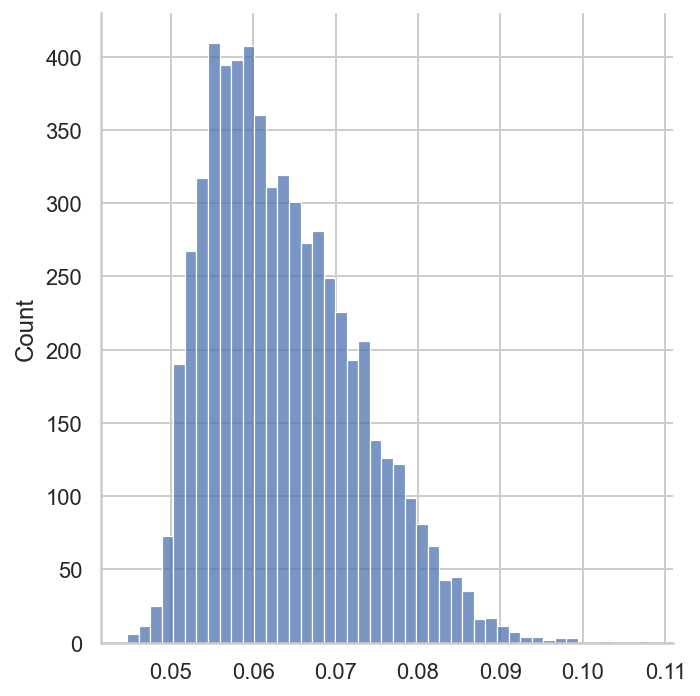

In [593]:
sns.displot((1/t).squeeze())

In [594]:
threshold = (1/t).squeeze().median()
mask = (1/t < threshold).squeeze().numpy()

In [595]:
dist_ovs = res.to_frame().apply(lambda x: dist_overlap(torch.tensor(x[0]), v[x.name]), axis=1)

In [677]:
dist_ovs.loc[~mask].mean()

0.6028526686096755

In [679]:
dist_ovs.loc[mask].std()

0.06655130875968848

In [596]:
dist_ovs.loc[~mask]

1       0.596443
2       0.666595
3       0.446030
7       0.627012
11      0.541642
          ...   
6030    0.524315
6031    0.765394
6032    0.591308
6033    0.558058
6037    0.577173
Length: 3021, dtype: float64

In [597]:
dist_df = pd.DataFrame(dict(overlap=dist_ovs.to_numpy(), conformity=(1/t).numpy().flatten(), low=mask))

In [598]:
#dist_df = dist_df.loc[(dist_df['conformity'] < 0.05) | (dist_df['conformity'] > 0.08)]

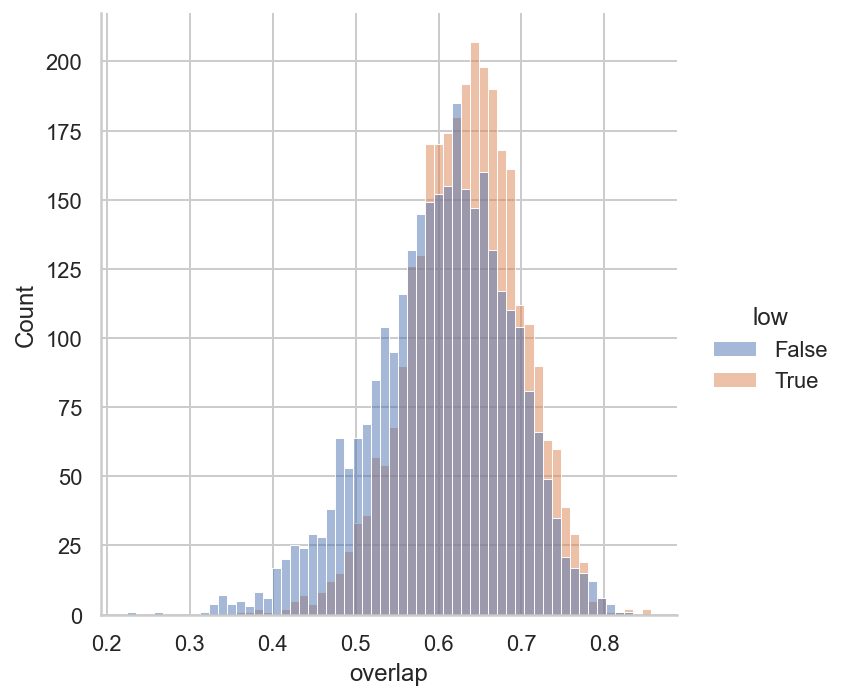

In [599]:
sns.displot(dist_df, x='overlap', hue='low')

Das ganze hier anschauen mit der popularity und dann cohen's d. für die conformität

## Individual user

In [622]:
user_id = 2685
v[user_id]

tensor([0.0000, 0.0597, 0.0000, 0.0000, 0.0158, 0.1098, 0.0134, 0.0000, 0.0000,
        0.0000, 0.0158, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3804, 0.0000,
        0.1011, 0.0010, 0.0000, 0.0000, 0.0000, 0.0640, 0.0288, 0.0710, 0.0000,
        0.0336, 0.0301, 0.0192, 0.0432, 0.0131])

In [604]:
v.argmax(keepdim=True)

tensor(85936)

In [605]:
v.shape

torch.Size([6040, 32])

In [607]:
85936 // 32

2685

<AxesSubplot:>

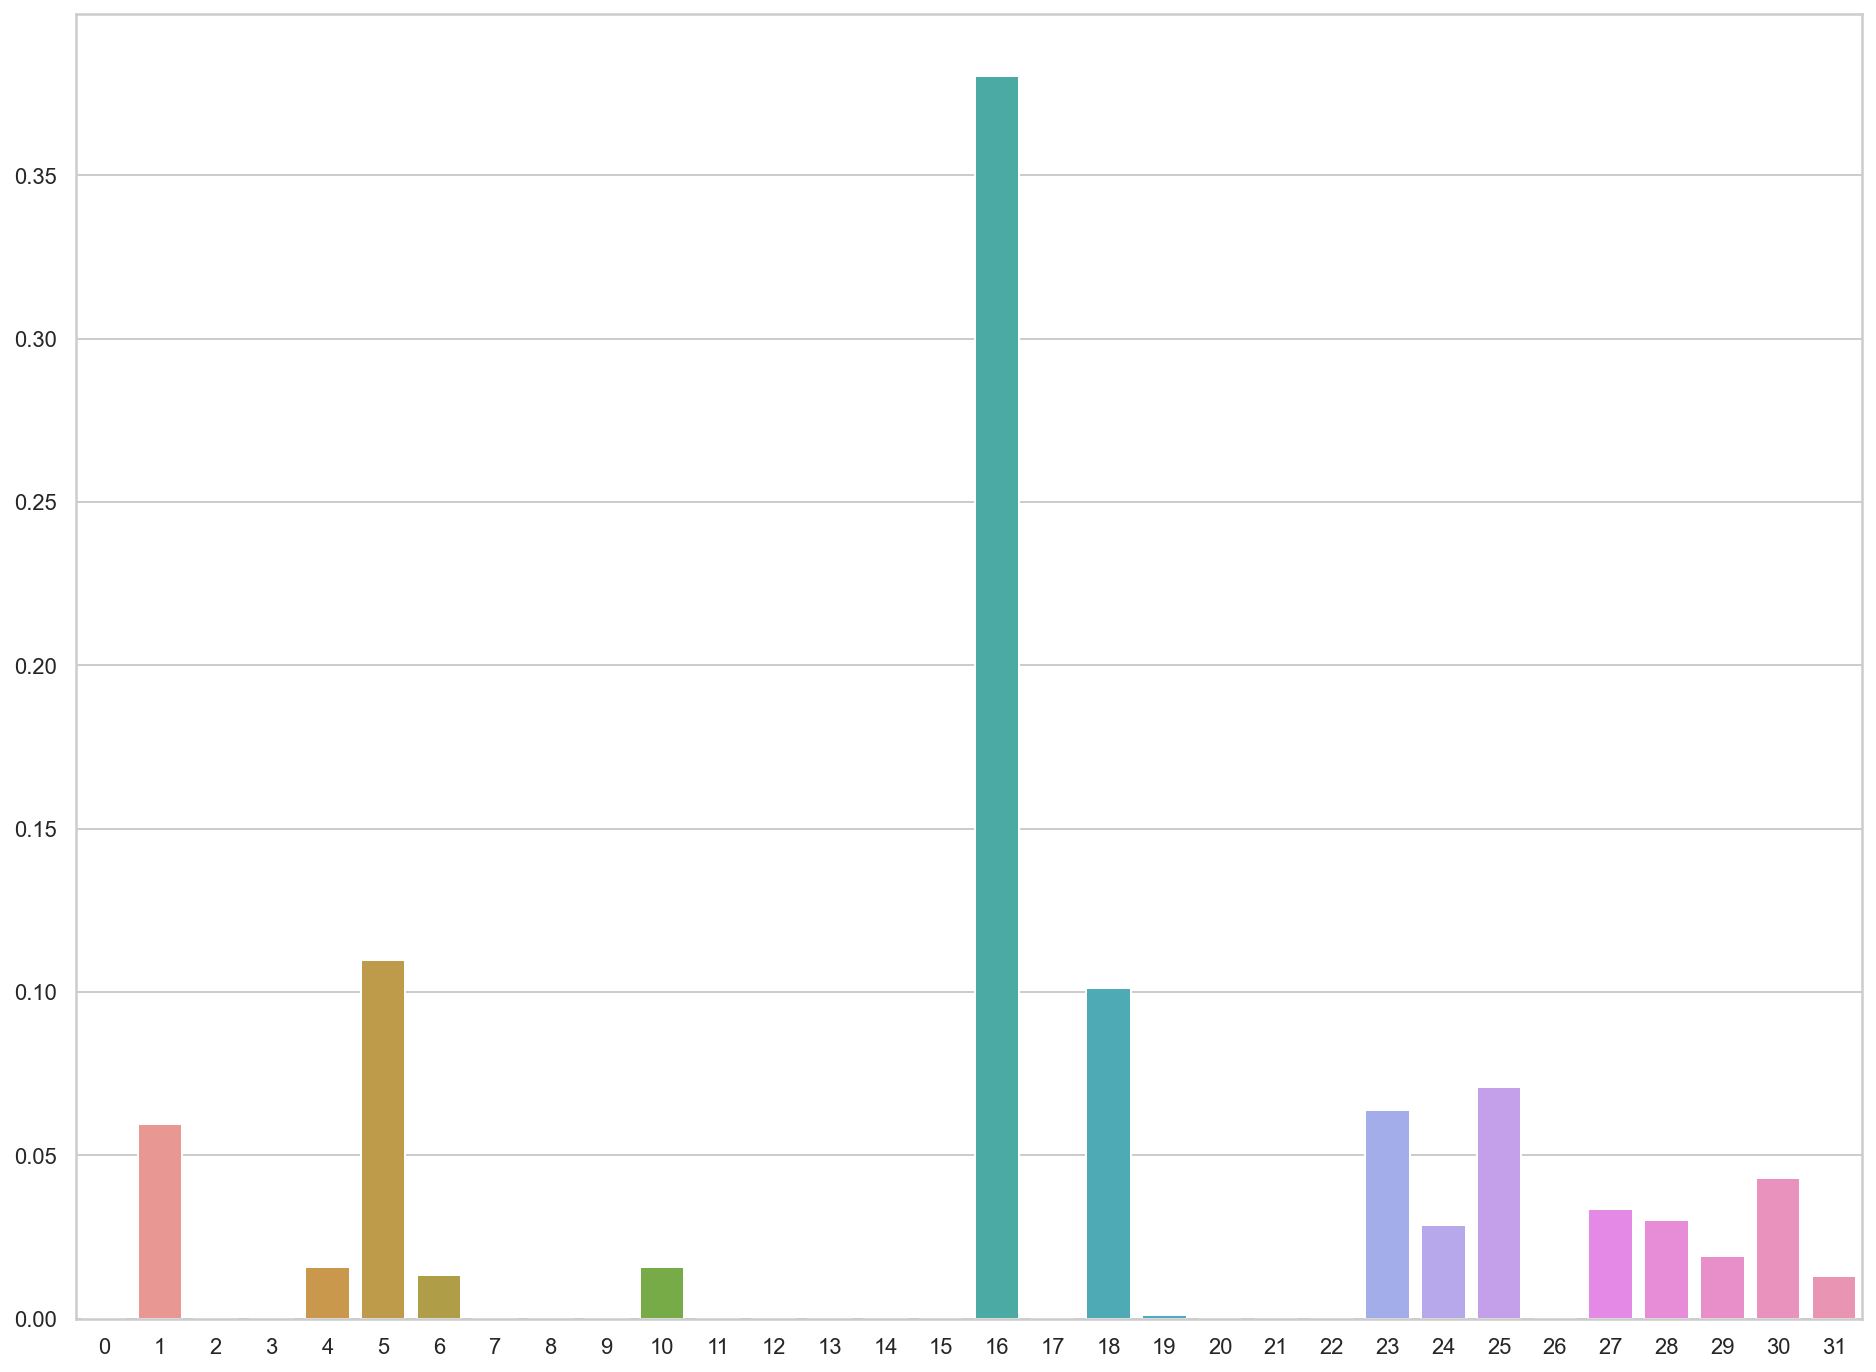

In [620]:
sns.barplot(x=np.arange(v.shape[1]), y=v[2685].numpy())

In [621]:
df = data.to_pandas()

In [627]:
items = df.query('user_id == 2685')['item_id'].to_numpy()

In [631]:
[h[i].argmax().item() for i in items]

[1, 18, 24, 3, 16, 16, 28, 28, 1, 24, 28, 16, 20, 3, 23, 16, 30, 6, 23, 16, 14]

<AxesSubplot:>

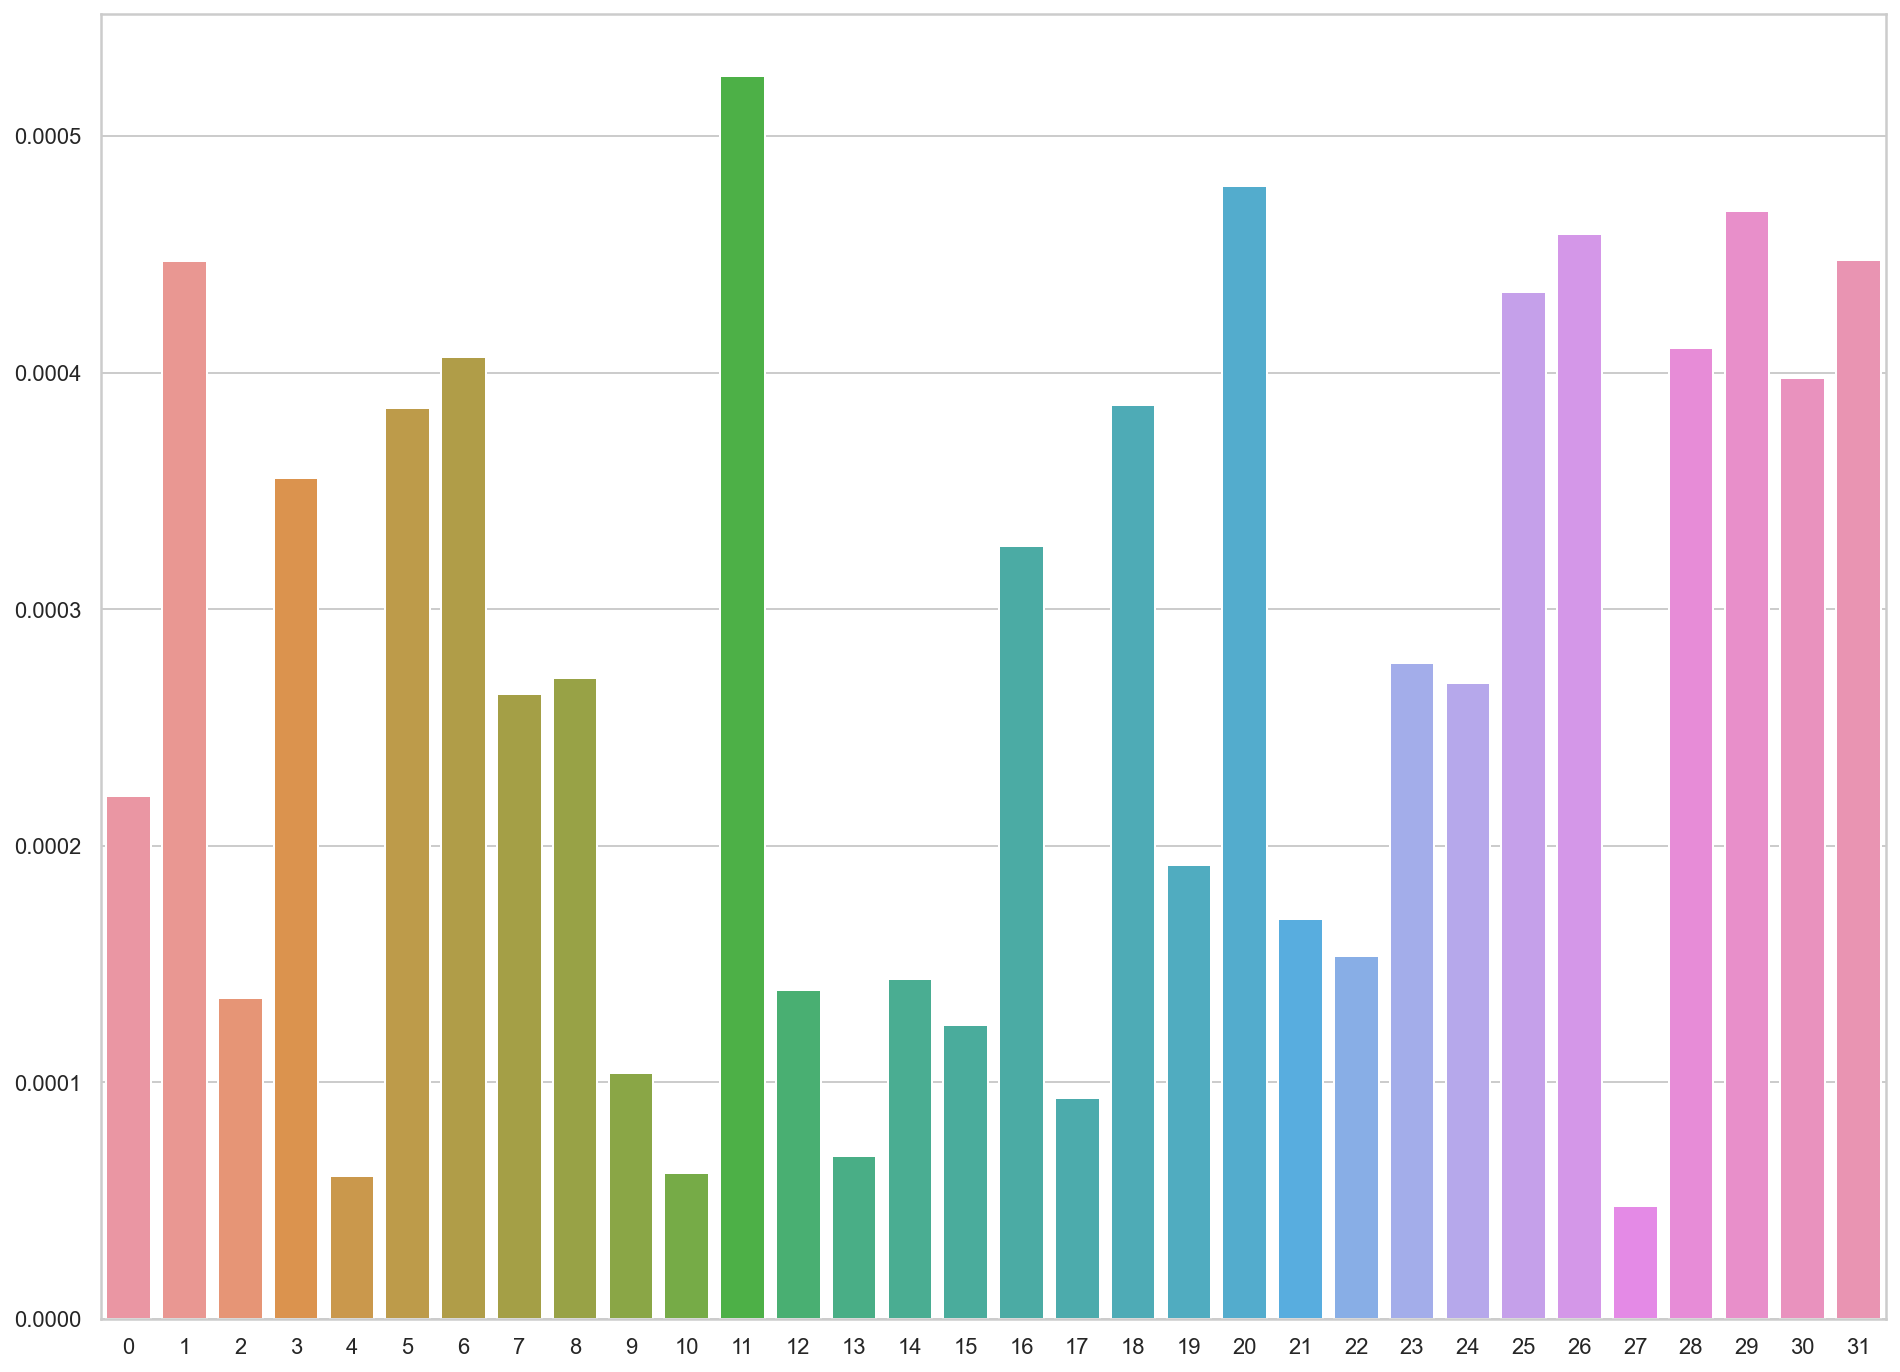

In [641]:
sns.barplot(x=np.arange(h.shape[1]), y=h[112].numpy()) 

<AxesSubplot:>

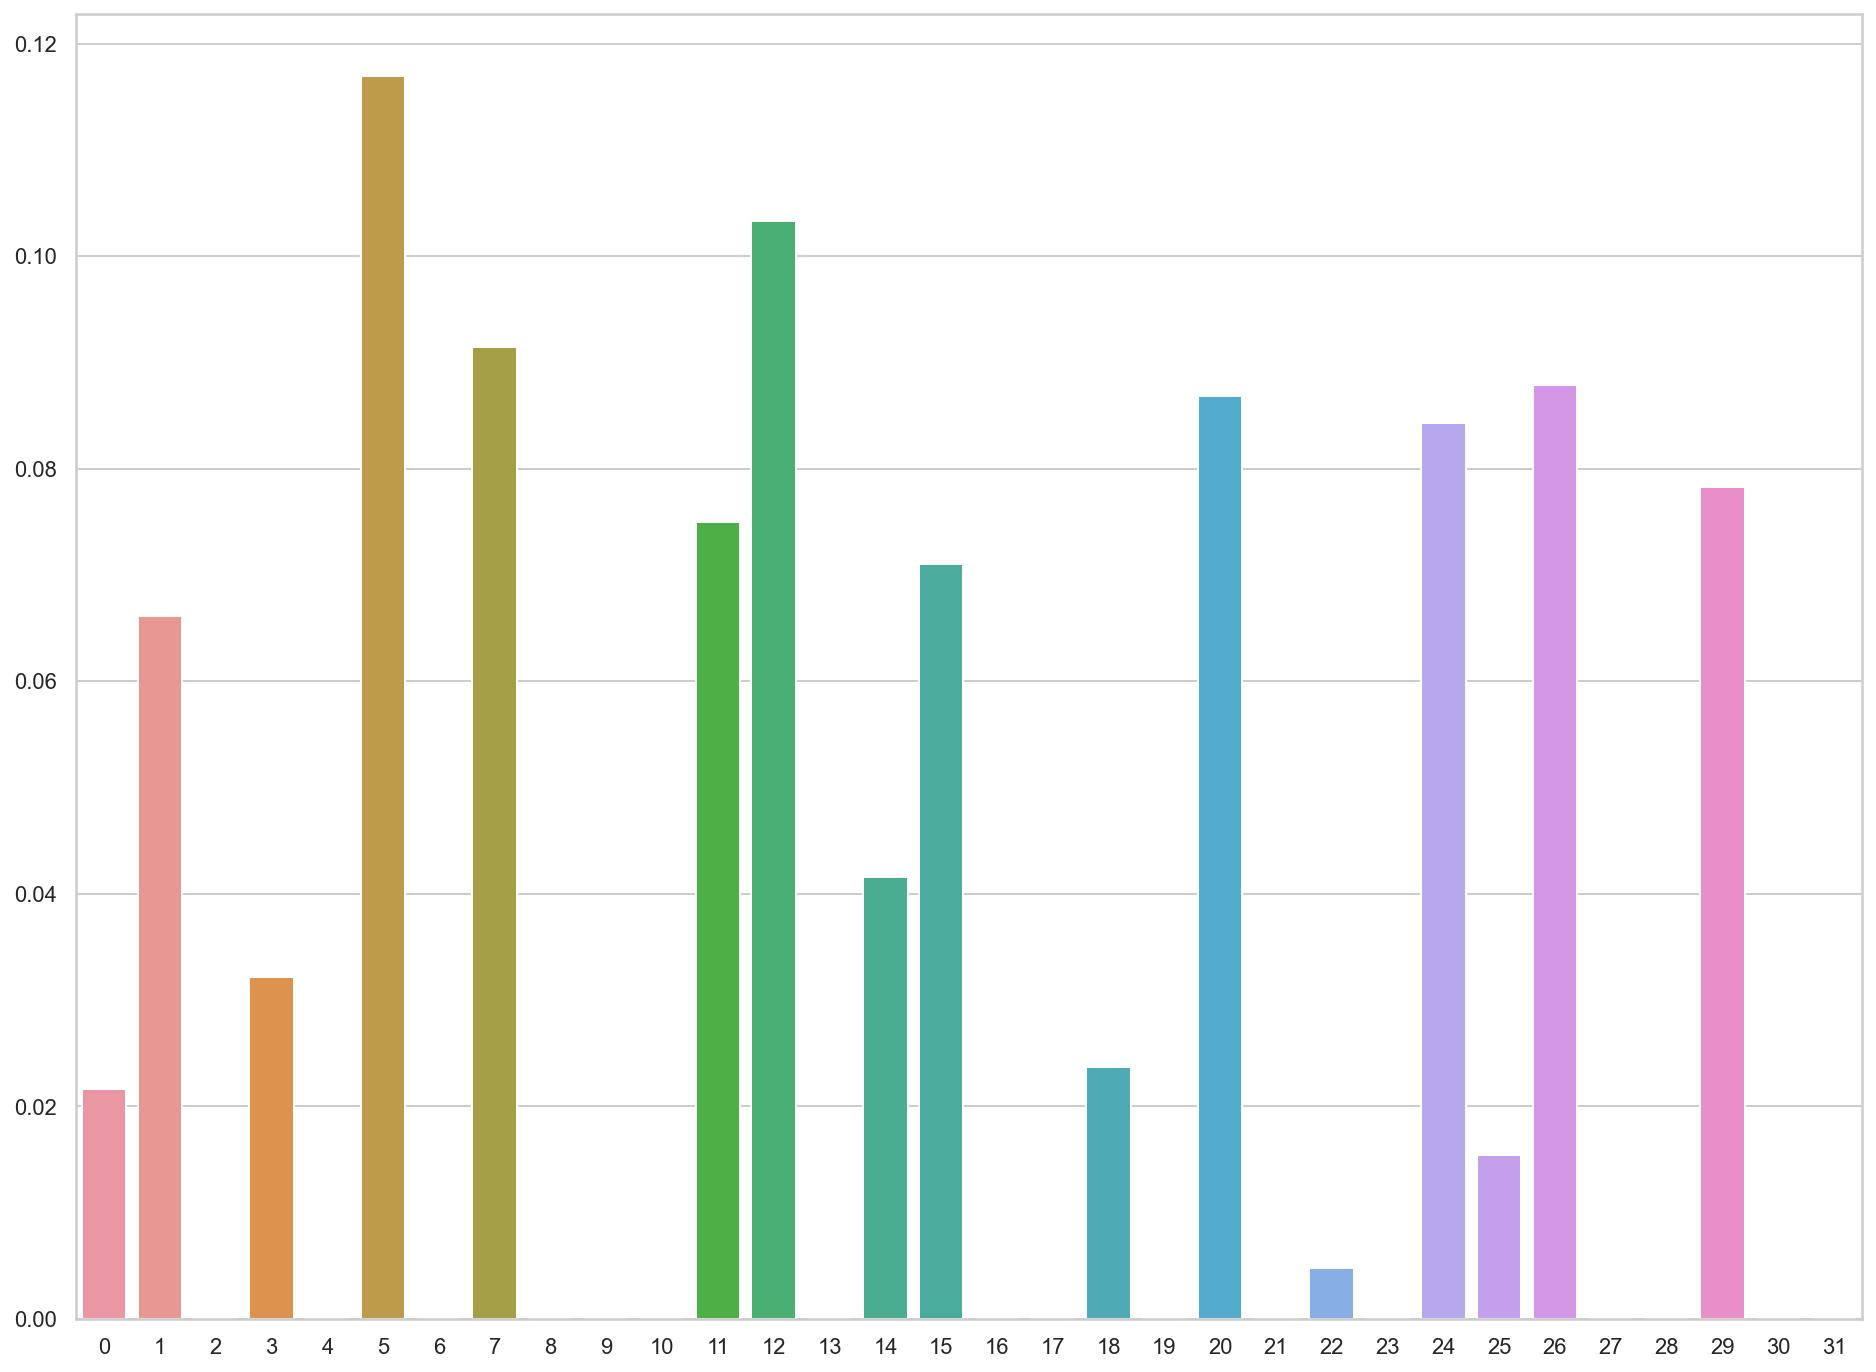

In [666]:
sns.barplot(x=np.arange(v.shape[1]), y=v[0].numpy()) 

<AxesSubplot:>

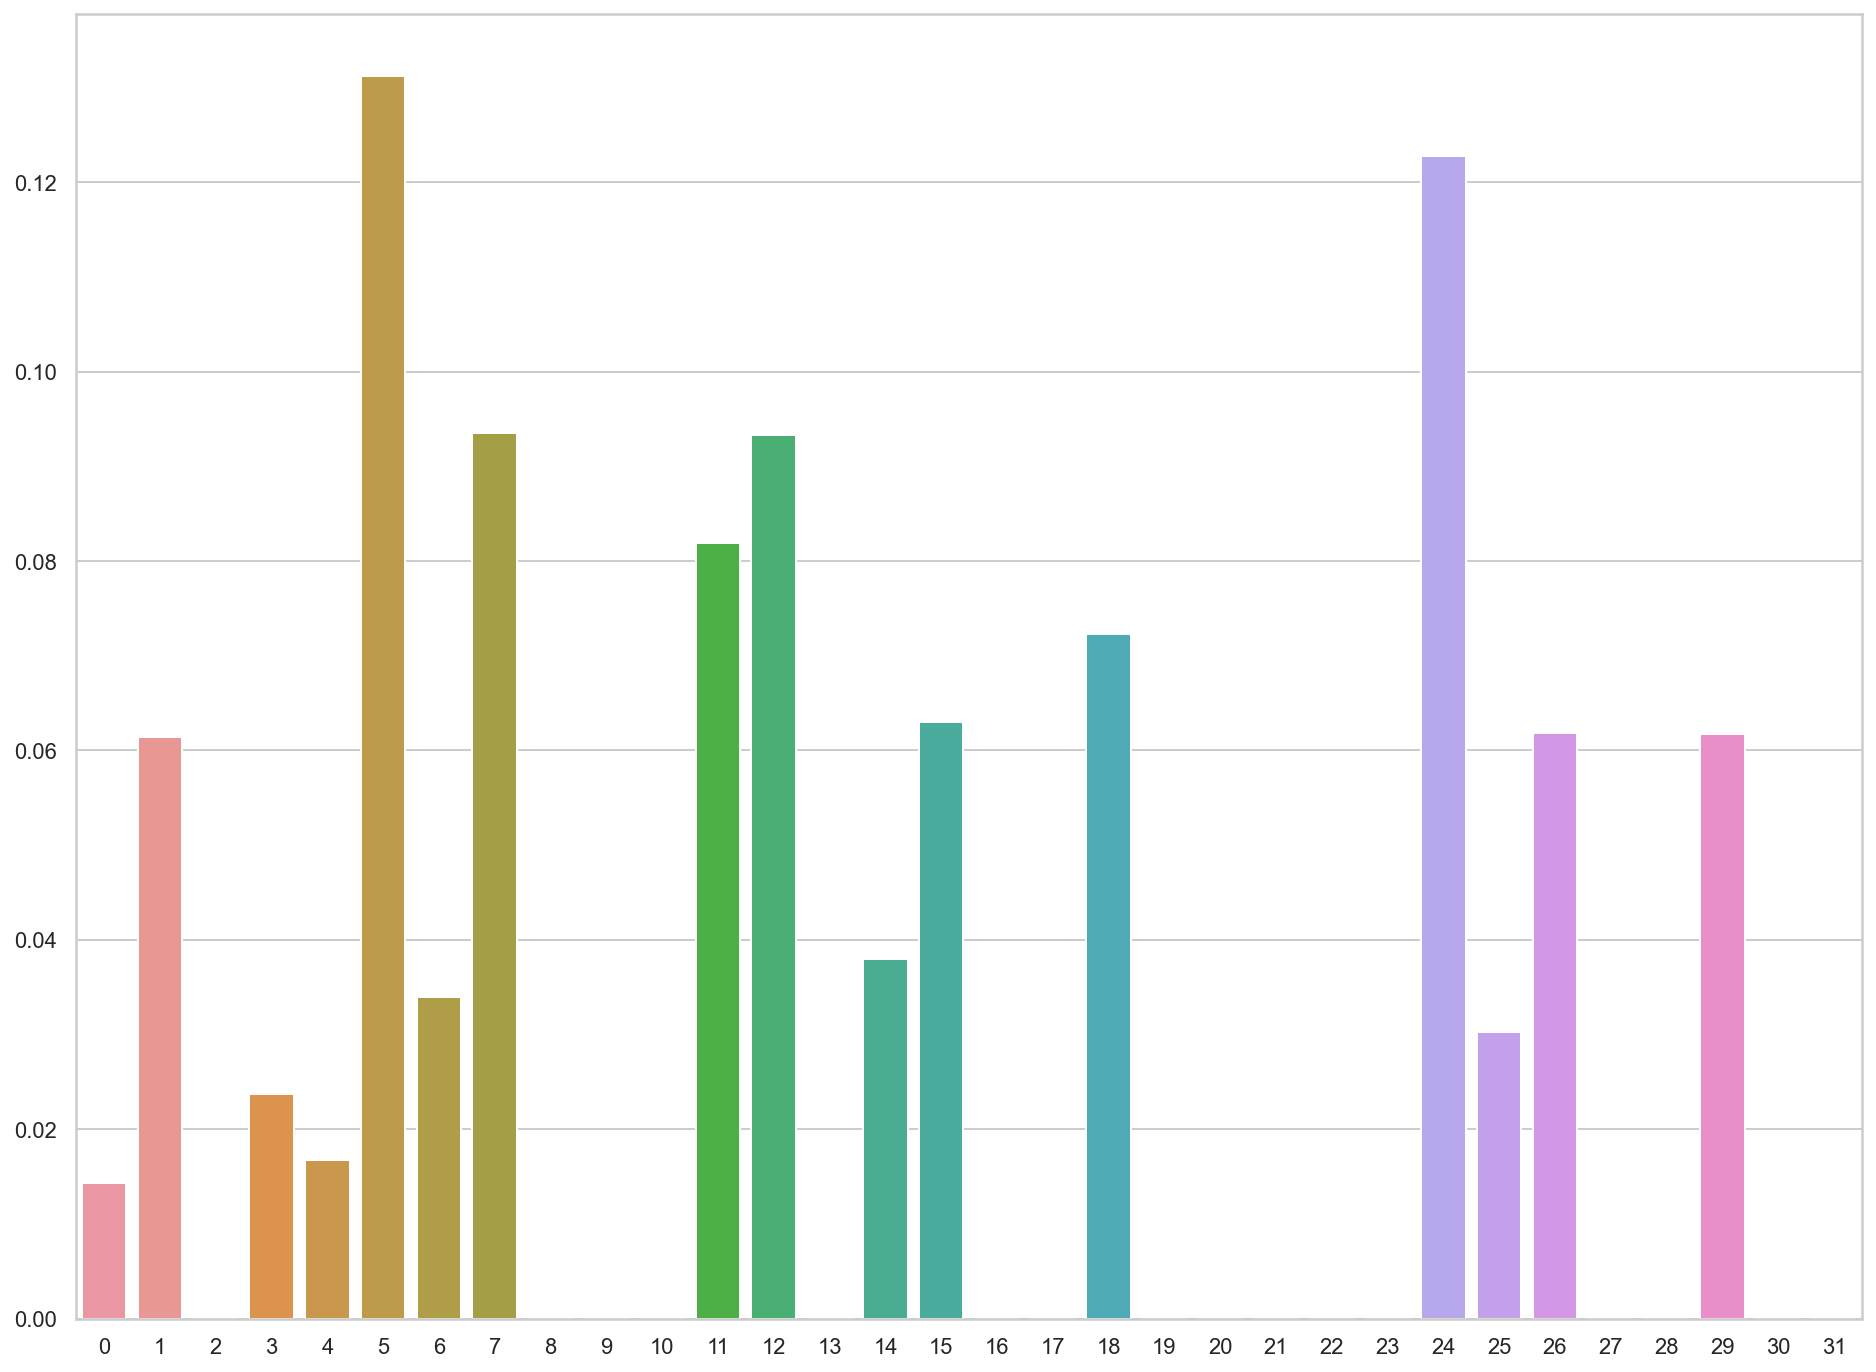

In [667]:
sns.barplot(x=np.arange(v.shape[1]), y=v[5886].numpy()) 

In [670]:
df[df['user_id'] == 0]['item_id'].to_numpy()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51], dtype=int32)

In [671]:
df[df['user_id'] == 5886]['item_id'].to_numpy()

array([   1,    3,    4,    6,    7,    8,    9,   12,   13,   15,   18,
         21,   25,   32,   36,   38,   39,   44,   49,   50,   52,   63,
         66,   81,   83,   86,   87,   95,  104,  115,  128,  134,  149,
        153,  156,  164,  167,  174,  177,  207,  275,  323,  381,  382,
        392,  414,  417,  420,  428,  435,  471,  525,  547,  553,  580,
        585,  596,  609,  612,  632,  662,  669,  688,  696,  726,  741,
        798,  823, 1042, 1046, 1070, 1109, 1195, 1321, 1531, 1594, 1623,
       1761, 1767, 2041, 2043, 2220], dtype=int32)

In [674]:
t[5886]

tensor([18.3384])

In [665]:
apply_along_dim(v, partial(dist_overlap, v[0]), dim=0).sort(descending=True)

torch.return_types.sort(
values=tensor([1.0000, 0.8240, 0.7572,  ..., 0.1261, 0.1245, 0.0961]),
indices=tensor([   0, 5886, 6014,  ...,  729, 3954,   45]))

In [657]:
v[2

tensor([0.0000, 0.0176, 0.0000, 0.0000, 0.0243, 0.0820, 0.0307, 0.0000, 0.0456,
        0.0000, 0.0000, 0.0418, 0.0393, 0.0000, 0.0000, 0.0000, 0.2100, 0.0000,
        0.1269, 0.0030, 0.0000, 0.0000, 0.0000, 0.1148, 0.0000, 0.1076, 0.0505,
        0.0000, 0.0000, 0.0283, 0.0771, 0.0006])

In [647]:
h[3559].sum()

tensor(0.0086)

In [645]:
h[3559]

tensor([0.0004, 0.0002, 0.0004, 0.0001, 0.0004, 0.0001, 0.0002, 0.0002, 0.0003,
        0.0004, 0.0004, 0.0002, 0.0004, 0.0004, 0.0003, 0.0003, 0.0002, 0.0004,
        0.0001, 0.0004, 0.0002, 0.0004, 0.0003, 0.0003, 0.0002, 0.0001, 0.0002,
        0.0004, 0.0001, 0.0001, 0.0002, 0.0002])